In [1]:
import numpy as np
import matplotlib.pyplot as plt
from swim import double_well, simple_md, simple_metad

np.set_printoptions(precision=5)

#### Take a look at our double well potential

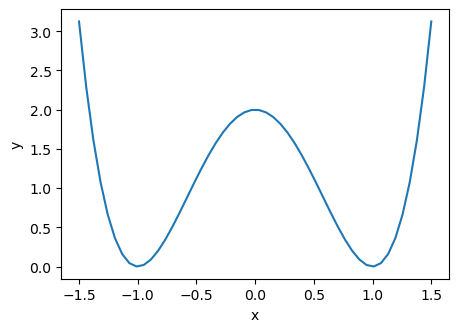

In [2]:
dw = double_well()
dw.param = {'B':2, 'x0':1}

x_arr = np.linspace(-1.5, 1.5, 50)
y_arr = dw.act(x_arr)

fig, ax = plt.subplots(figsize=(5,3.5), nrows=1, ncols=1)
ax.plot(x_arr, y_arr)
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

#### An MD at kT=0.1 cannot sample this double well potential well.

In [3]:
dw = double_well()
dw.param = {'B':2., 'x0':1.}

md = simple_md(seed=45932)
md.set_param(dt=0.01, kT=0.1, damping=10.)
md.set_init_x(-1.06)

md.external_pe = [dw]
md.run(int(1e6))

#### Our MD system get trapped in the initial basin,

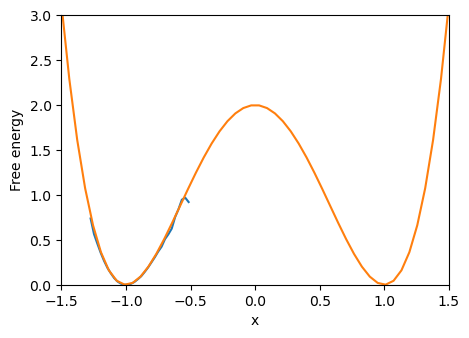

In [4]:
x = [row[1] for row in md.traj]

hist = np.histogram(x, bins=30)
prob = hist[0]/np.sum(hist[0])
mids = 0.5*(hist[1][:-1]+hist[1][1:])
free_energy = -md.kT*np.log(prob+1e-11)
free_energy -= np.min(free_energy)

fig, ax = plt.subplots(figsize=(5,3.5), nrows=1, ncols=1)
ax.plot(mids, free_energy)
ax.plot(x_arr, y_arr)
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(0, 3)

ax.set_xlabel('x')
ax.set_ylabel('Free energy')
plt.show()

#### See how large the thermal fluctuation is

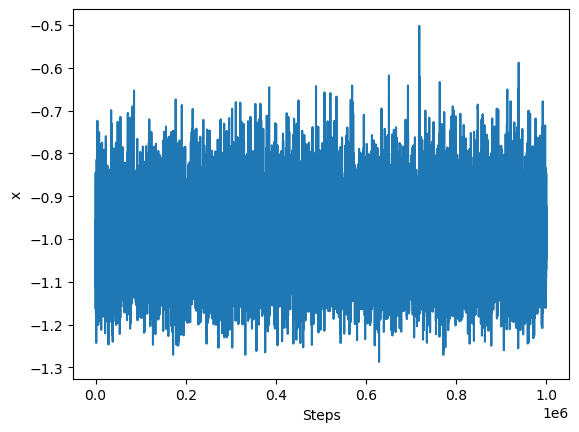

Size of fluctuation: 0.08179136646139437


In [13]:
x = [row[1] for row in md.traj]

plt.plot(x)
plt.xlabel('Steps')
plt.ylabel('x')
plt.show()

print('Size of fluctuation:', np.std(x))

#### A metadynamics model for testing various sigma values.

In [5]:
def metad_model(idx, sigma):
    """
    Generate a metadynamics simulation with Guassian bias width = sigma.
    """
    dw = double_well()
    dw.param = {'B':2., 'x0':1.}

    metad = simple_metad(seed=45932)
    metad.set_param(dt=0.01, kT=0.1, damping=10.)
    metad.set_init_x(-1.06)
    metad.set_metad(init_h=0.2, sigma=sigma, stride=1000, bias_factor=10.)

    metad.external_pe = [dw]
    metad.run(int(5e5))
    
    np.savetxt('./DATA/metad_{}'.format(idx), np.array(metad.traj[::10])[:,:2])
    np.savetxt('./DATA/bias_{}'.format(idx), np.vstack((metad.h_t, metad.x_t)).T)
    np.savetxt('./DATA/vbias_{}'.format(idx), metad.vbias[::10])
    
sigmas = [0.04, 0.08, 0.2, 0.4]
for idx, sigma in enumerate(sigmas):
    metad_model(idx, sigma)

#### Comparing simulation with analytical free energy

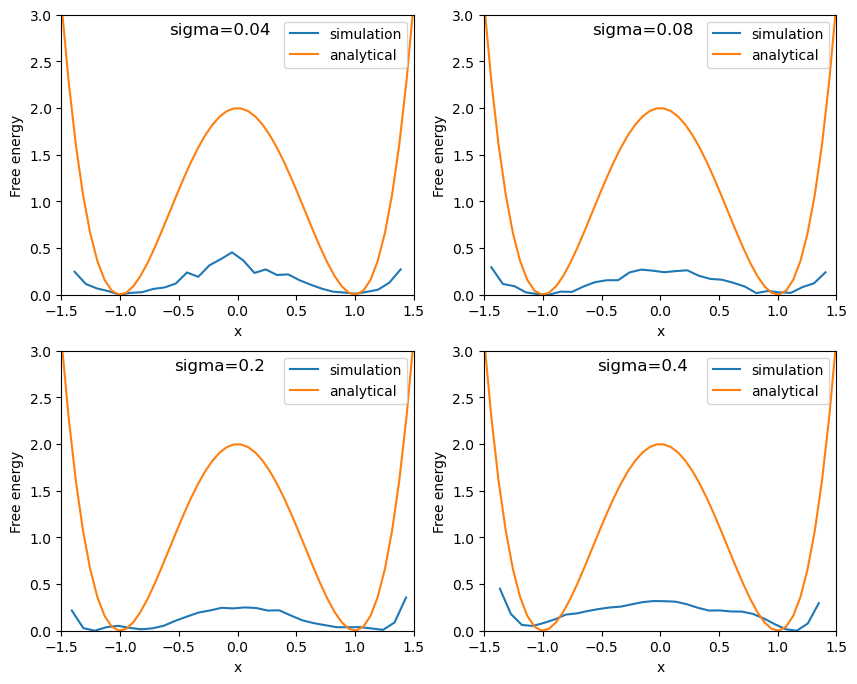

In [6]:
kT=0.1

fig, ax = plt.subplots(figsize=(10,8), nrows=2, ncols=2)
ax = ax.flatten()

def unreweighted_plot(idx, sigma):
    
    step, x = np.loadtxt('./DATA/metad_{}'.format(idx), unpack=True)

    hist = np.histogram(x, bins=30)
    prob = hist[0]/np.sum(hist[0])
    mids = 0.5*(hist[1][:-1]+hist[1][1:])
    free_energy = -kT*np.log(prob+1e-11)
    free_energy -= np.min(free_energy)

    ax[idx].plot(mids, free_energy, label='simulation')
    ax[idx].plot(x_arr, y_arr, label='analytical')
    
    ax[idx].set_title('sigma={}'.format(sigma), x=0.45, y=0.9)
    ax[idx].set_xlim(-1.5, 1.5)
    ax[idx].set_ylim(0, 3)

    ax[idx].set_xlabel('x')
    ax[idx].set_ylabel('Free energy')
    ax[idx].legend()

for idx, sigma in enumerate(sigmas):
    
    unreweighted_plot(idx, sigma)

plt.show()

#### A copy of our metadynamics parameters and the gaussian bias function

In [7]:
kT = 0.1
bias_factor = 10.0
gamma = bias_factor
pref = gamma/(gamma-1)

def gauss_bias(x, h_t, x_t, sigma):
    """
    A copy of gaussian bias we used in metadynamics.
    """
    h_t = np.array(h_t)
    x_t = np.array(x_t)

    dx = x - x_t
    gauss_e = h_t * np.exp(-0.5 * dx**2 / sigma**2)

    return np.sum(gauss_e), None

#### Comparing reweighted and analytical free energy

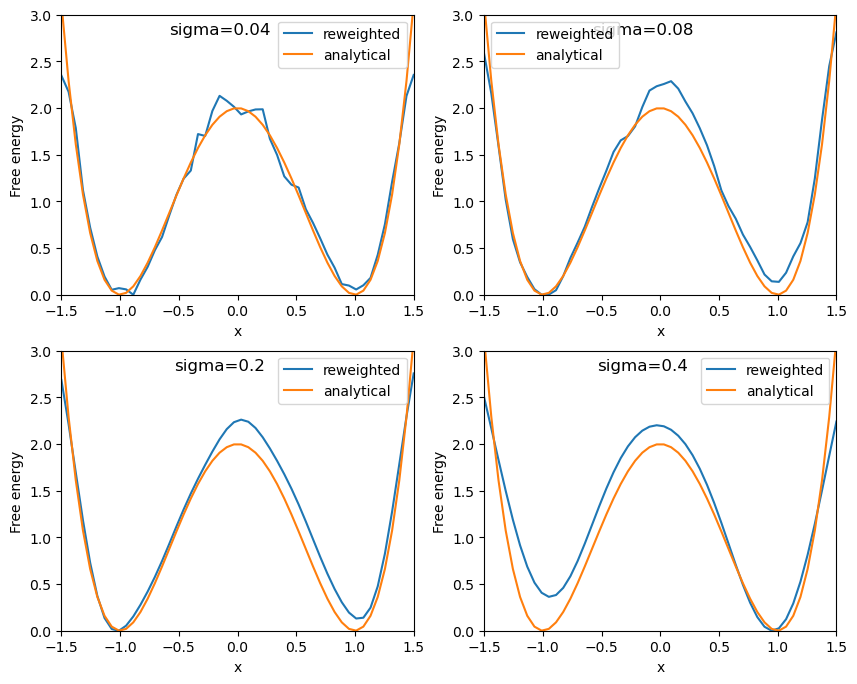

In [8]:
fig, ax = plt.subplots(figsize=(10,8), nrows=2, ncols=2)
ax = ax.flatten()

def reweighted_plot(idx, sigma):
    
    step, x = np.loadtxt('./DATA/metad_{}'.format(idx), unpack=True)
    h_t, x_t = np.loadtxt('./DATA/bias_{}'.format(idx), unpack=True)

    yr_arr = np.array([-pref * gauss_bias(xi, h_t, x_t, sigma)[0] for xi in x_arr])
    yr_arr -= np.min(yr_arr)
    
    ax[idx].plot(x_arr, yr_arr, label='reweighted')
    ax[idx].plot(x_arr, y_arr, label='analytical')
    
    ax[idx].set_title('sigma={}'.format(sigma), x=0.45, y=0.9)
    ax[idx].set_xlim(-1.5, 1.5)
    ax[idx].set_ylim(0, 3)
    
    ax[idx].set_xlabel('x')
    ax[idx].set_ylabel('Free energy')
    ax[idx].legend()
    

for idx, sigma in enumerate(sigmas):
    
    reweighted_plot(idx, sigma)

plt.show()

#### Plot the trajectories and the accumulations of bias

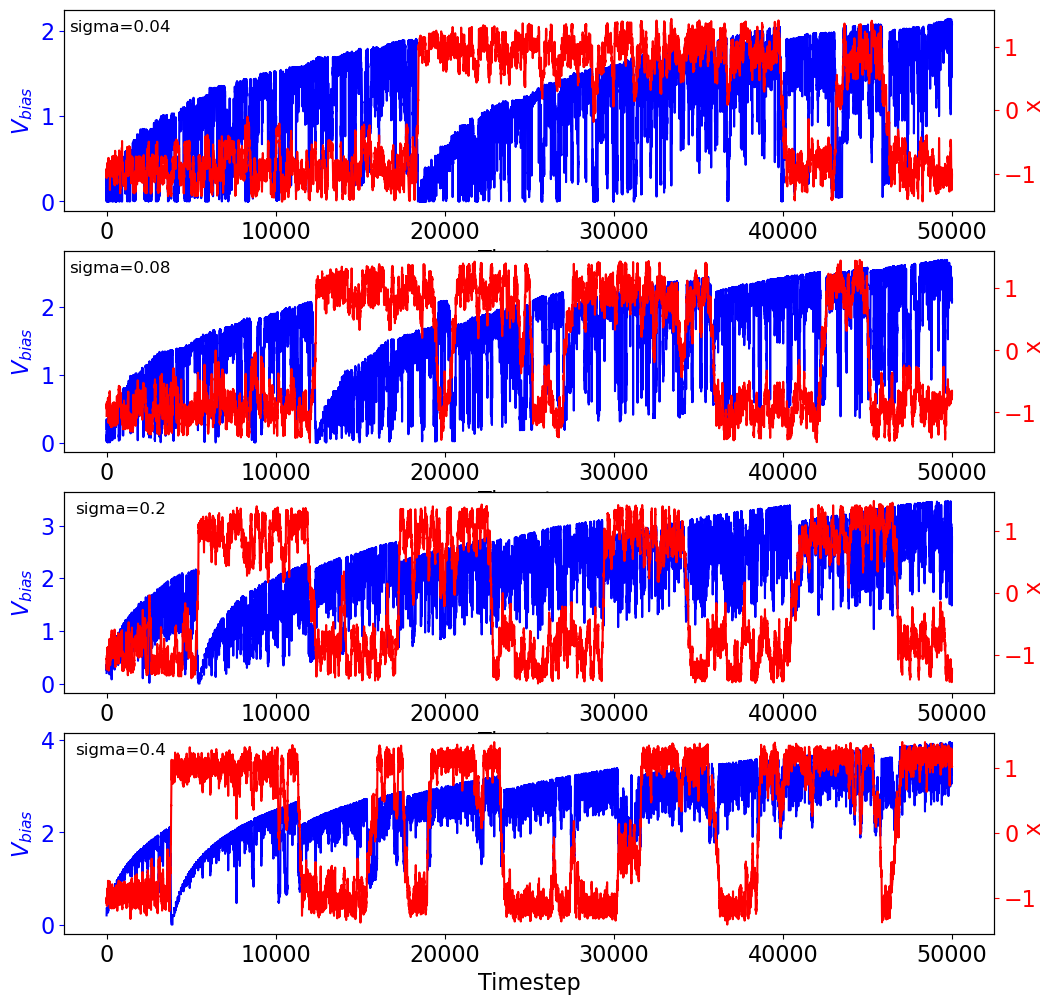

In [9]:
fig, ax = plt.subplots(figsize=(12,12), nrows=4, ncols=1)
ax = ax.flatten()
axr = {}

def traj_plot(idx, sigma):
    
    step, x = np.loadtxt('./DATA/metad_{}'.format(idx), unpack=True)
    vbias = np.loadtxt('./DATA/vbias_{}'.format(idx), unpack=True)
    
    axr[idx]=ax[idx].twinx()

    ax[idx].plot(vbias, 'b-', label='spectral gap')
    axr[idx].plot(x, 'r-', fillstyle='none', label='$\Lambda$')

    ax[idx].set_title('sigma={}'.format(sigma), x=0.06, y=0.85)
    ax[idx].tick_params('y', colors='b', which='major', labelsize=16)
    ax[idx].set_xlabel('Timestep', size=16)
    ax[idx].set_ylabel('$V_{bias}$', color='b', size=16)
    ax[idx].tick_params('x', colors='k', which='major', labelsize=16)
    
    axr[idx].set_ylabel('x', color='r', size=16)
    axr[idx].yaxis.set_label_coords(1.03, 0.525)
    axr[idx].tick_params('y', colors='r', which='major', labelsize=16)


for idx, sigma in enumerate(sigmas):
    
    traj_plot(idx, sigma)

# plt.gcf().subplots_adjust(left=0.15, right=0.98) # to make room for the label
# plt.savefig('output/vbias', dpi=300)
plt.show()

#### Plot the instantaneous biased potentials

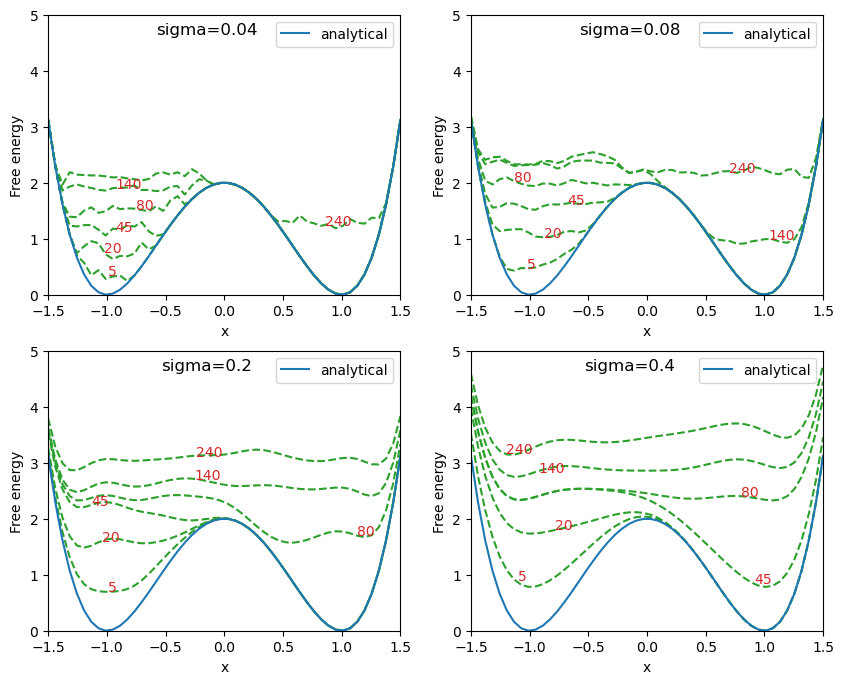

In [10]:
x_arr = np.linspace(-1.5, 1.5, 50)

fig, ax = plt.subplots(figsize=(10,8), nrows=2, ncols=2)
ax = ax.flatten()

def instant_plot(idx, sigma):
    
    step, x = np.loadtxt('./DATA/metad_{}'.format(idx), unpack=True)
    h_t, x_t = np.loadtxt('./DATA/bias_{}'.format(idx), unpack=True)
    
    for step in [5, 20, 45, 80, 140, 240]:
        yr_arr = y_arr + np.array([pref * gauss_bias(xi, h_t[:step], x_t[:step], sigma)[0] for xi in x_arr])
        ax[idx].plot(x_arr, yr_arr, 'C2--')
        
        idx_xpos = np.where(np.abs(x_arr-x_t[step])<0.1)
        ax[idx].annotate( '{}'.format(step), xy=(x_t[step], yr_arr[idx_xpos].mean()), c='C3' )
    
    ax[idx].plot(x_arr, y_arr, label='analytical')
    
    ax[idx].set_title('sigma={}'.format(sigma), x=0.45, y=0.9)
    ax[idx].set_xlim(-1.5, 1.5)
    ax[idx].set_ylim(0, 5)
    
    ax[idx].set_xlabel('x')
    ax[idx].set_ylabel('Free energy')
    ax[idx].legend()

for idx, sigma in enumerate(sigmas):
    
    instant_plot(idx, sigma)

plt.show()

#### Making metadynamics videos

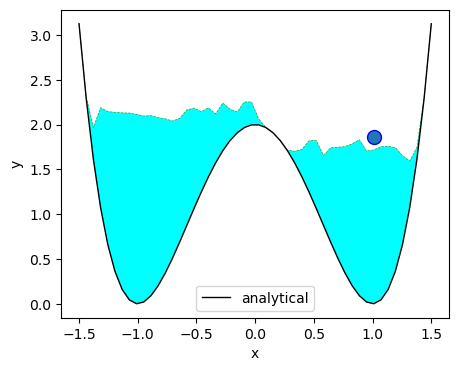

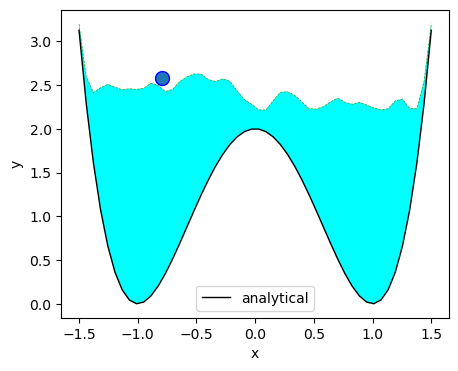

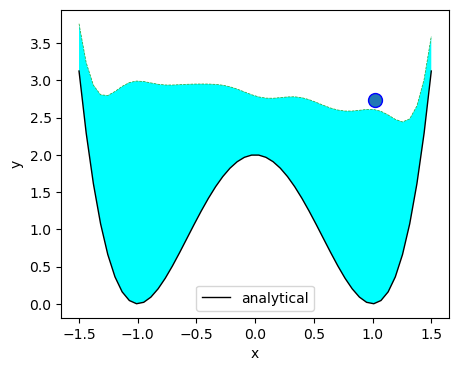

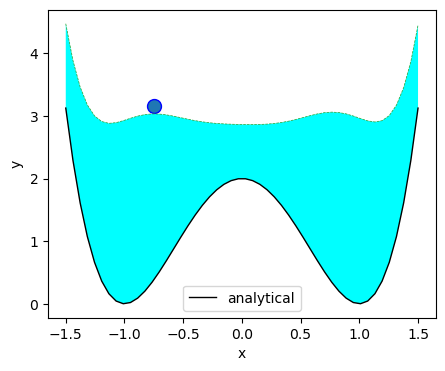

In [11]:
from matplotlib.animation import FuncAnimation

x_arr = np.linspace(-1.5, 1.5, 50)
frame_arr = [300, 270, 180, 150]

def metad_video(idx, sigma):
    
    h_t, x_t = np.loadtxt('./DATA/bias_{}'.format(idx), unpack=True)
    
    fig, ax = plt.subplots(figsize=(5, 4), nrows=1, ncols=1)
    ax.set_title('sigma={}'.format(sigma), y=0.9)
    ax.set_xlabel('x')
    ax.set_ylabel('y')

    # create a function to update the plot in each animation frame
    def update(frame):
        ax.clear()
        ax.set_xlabel('x')
        ax.set_ylabel('y')

        x_frame = x_t[frame]
        y_frame = dw.act(x_t[frame]) + pref * gauss_bias(x_frame, h_t[:frame], x_t[:frame], sigma)[0]

        yr_arr = y_arr + np.array([pref * gauss_bias(xi, h_t[:frame], x_t[:frame], sigma)[0] for xi in x_arr])

        ax.scatter(x_frame, y_frame+0.13, s=100, edgecolors='b')
        ax.plot(x_arr, yr_arr, 'C2--', linewidth=0.5)
        ax.plot(x_arr, y_arr, 'k-', linewidth=1.0, label='analytical')

        ax.fill_between(x_arr, y_arr, yr_arr, facecolor='cyan', interpolate=True)
        ax.legend()

    # Create the animation
    ani = FuncAnimation(fig, update, frames=frame_arr[idx], interval=200, repeat=False)
    ani.save('output/metad_anim_{}.gif'.format(idx), writer='pillow')

    plt.show()
    
for idx, sigma in enumerate(sigmas):
    metad_video(idx, sigma)
    